# Machine Learning: Landing Success Prediction

## Objective
Build and evaluate machine learning models to predict the probability
of a successful Falcon 9 first-stage landing based on launch
characteristics.

This notebook completes the end-to-end data science pipeline by
transitioning from exploratory analysis to predictive modeling.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import joblib


In [16]:
df = pd.read_csv("../data/processed/spacex_api_clean.csv")
df.shape


(205, 10)

## Feature Selection

Based on EDA insights, the following features are used for prediction:
- Launch site
- Rocket configuration
- Launch year

These features capture operational, temporal, and categorical
characteristics relevant to landing success.


In [17]:
df["launch_year"] = pd.to_datetime(df["launch_date"]).dt.year

# 'rocket' refers to the rocket configuration/name column in the cleaned dataset
features = ["launchpad", "rocket", "launch_year"]
target = "landing_success"

X = df[features]
y = df[target]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Data Preprocessing

Categorical variables are encoded using one-hot encoding,
while numerical features are standardized.


In [19]:
categorical_features = ["launchpad", "rocket"]
numerical_features = ["launch_year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)


## Model Training and Evaluation

Multiple classification models are trained and compared to assess
their ability to predict landing success.


In [20]:
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)


In [21]:
tree_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)


In [22]:
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)


In [23]:
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]


In [24]:
roc_auc = roc_auc_score(y_test, y_proba_rf)
roc_auc


0.8250000000000002

In [25]:
def evaluate_model(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }


In [26]:
results = pd.DataFrame({
    "Logistic Regression": evaluate_model(y_test, y_pred_lr),
    "Decision Tree": evaluate_model(y_test, y_pred_tree),
    "Random Forest": evaluate_model(y_test, y_pred_rf),
}).T

results


,accuracy,precision,recall,f1_score
Logistic Regression,0.853659,0.875000,0.972222,0.921053
Decision Tree,0.878049,0.897436,0.972222,0.933333
Random Forest,0.878049,0.897436,0.972222,0.933333


In [27]:
# Prepare metrics table for export
metrics_df = (
    results
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("f1_score", ascending=False)
)

metrics_df


,model,accuracy,precision,recall,f1_score
1,Decision Tree,0.878049,0.897436,0.972222,0.933333
2,Random Forest,0.878049,0.897436,0.972222,0.933333
0,Logistic Regression,0.853659,0.875000,0.972222,0.921053


In [28]:
# Save metrics for portfolio
metrics_df.to_csv("../models/metrics/model_comparison.csv", index=False)


## Confusion Matrix (Best Model)

The confusion matrix provides insight into the types of
classification errors made by the model.


In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix


array([[ 1,  4],
       [ 1, 35]])

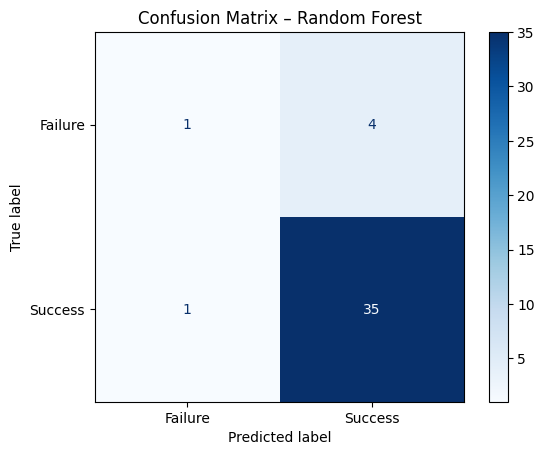

In [30]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["Failure", "Success"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Random Forest")

plt.savefig(
    "../models/metrics/confusion_matrix_random_forest.png",
    dpi=150,
    bbox_inches="tight"
)

plt.show()


## Model Interpretation

The Random Forest model achieves the best overall performance,
suggesting that non-linear relationships between launch
characteristics and landing success exist.

Temporal trends and launch site differences play a significant
role in predictive performance.


In [31]:
joblib.dump(
    rf_clf,
    "../models/trained_models/random_forest_pipeline.pkl"
)

['../models/trained_models/random_forest_pipeline.pkl']

## Limitations

- The dataset size is relatively small.
- Payload mass and orbital parameters were not included in modeling.
- Results should be interpreted as indicative rather than definitive.

Future work could incorporate additional features and
hyperparameter tuning.


## Conclusion

This project demonstrates an end-to-end data science workflow,
from data collection and cleaning to exploratory analysis and
machine learning modeling.

The results show that landing success can be reasonably predicted
using launch site, rocket configuration, and temporal features,
highlighting the value of structured historical launch data.
